In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import cv2
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import MinMaxScaler
import os
from PIL import Image
import zipfile as zf

In [2]:
folder_path = 'chest_data/NORMAL'
num_samples = 300

#dim_1 = 0
#dim_2 = 0
#count = 0
#for root, dirs, files in os.walk(folder_path, topdown=False):
#    for name in files:
#        image = Image.open(os.path.join(root, name))
#        size = image.size
#        dim_1 = dim_1 + size[0]
#        dim_2 = dim_2 + size[1]
#        count += 1

#av_dim1 = dim_1 / count
#av_dim2 = dim_2 / count
#print(av_dim1)
#print(av_dim2)

# resize the images
data_matrix = []

counter = 0
for root, dirs, files in os.walk(folder_path, topdown=False):
    for name in files:
        if counter < num_samples:
            image = Image.open(os.path.join(root, name))
            image_array = np.asarray(image)
            image_resized = cv2.resize(image_array, (1667, 1381))
            image_1D = image_resized.reshape([-1])
            if np.shape(image_1D)[0] == 2302127:
                data_matrix.append(image_1D)
            else:
                counter -= 1
        else:
            break
        counter += 1

data_matrix_infected = []

infected_folder_path = 'chest_data/PNEUMONIA'

counter = 0
for root, dirs, files in os.walk(infected_folder_path, topdown=False):
    for name in files:
        if counter < num_samples:
            image = Image.open(os.path.join(root, name))
            image_array = np.asarray(image)
            image_resized = cv2.resize(image_array, (1667, 1381))
            image_1D = image_resized.reshape([-1])

            if np.shape(image_1D)[0] == 2302127:
                data_matrix_infected.append(image_1D)
            else:
                counter -= 1
        else:
            break
        counter += 1

print('images resized')

images resized


In [3]:
train_data = np.concatenate((np.asarray(data_matrix), np.asarray(data_matrix_infected)), axis=0)
train_data = MinMaxScaler().fit_transform(train_data)

label_0 = [0] * num_samples
label_1 = [1] * num_samples
label = np.concatenate((np.asarray(label_0), np.asarray(label_1)), axis=0)
train_data_labels = np.hstack((train_data, np.reshape(label, (-1, 1))))

# Running GMM

In [4]:
from scipy.stats import multivariate_normal as mvn
import copy
from sklearn.cluster import KMeans

class custom_gmm():
    #initialize gmm for dataset and k classes
    def __init__(self, data, k, cov_init=1, kmeans=True):
        self.data = copy.deepcopy(data)
        self.k = k
        self.n = len(self.data)
        self.f = len(self.data[0])
        #run kmeans and use centroids for decent mu initialization
        if kmeans:
            kmeans = KMeans(n_clusters=k).fit(self.data)
            self.mus = kmeans.cluster_centers_
        else:
            self.mus = self.data[np.random.choice(np.arange(self.n), self.k)]
        #initialize k covariance matrices as identity matrices
        self.covs = np.array([np.asmatrix(np.identity(self.f)) for i in range(self.k)]) * cov_init
        #intialize all mixes as equal
        self.mixes = np.ones(self.k) / self.k
        #initialize class likelihood probabilities as empty
        self.probs = np.empty((self.n, self.k))
        
    #assign probabilities each data point is in each class
    def e_step(self):
        s = 0
        for i in range(self.k):
            p = mvn.pdf(self.data, self.mus[i,:].ravel(), self.covs[i,:]) * self.mixes[i]
            s += p
            self.probs[:,i] = p
        self.probs = self.probs / s[:,None]
        
    #update mixer, mu, and cov matrix for each class
    def m_step(self):
        for i in range(self.k):
            #update mixer
            s = self.probs[:,i].sum()
            self.mixes[i] = s / self.n 
            #update mu
            new_mu = self.data.T @ self.probs[:, i]
            self.mus[i] = new_mu.reshape(1,self.f) / s
            #update cov
            dif = self.data - self.mus[i]
            diag = np.diag(np.diag(np.diag(self.probs[:,i])))
            new_cov = (diag @ dif).T @ dif
            self.covs[i] = new_cov / s
            
    #get log likelihood of model at its current stage
    def log_like(self):
        like = 0
        for i in range(self.k):
            like += mvn.pdf(self.data, self.mus[i,:].ravel(), self.covs[i,:]) * self.mixes[i]
        ll = np.log(like).sum()
        return ll
    
    #fit k gaussians to data until convergence within threshold
    def fit(self, thresh = 0.0001):
        like = 1
        prev_like = 0
        #perform e step then m step until log likelihood converges
        while np.abs(like - prev_like) > thresh:
            prev_like = self.log_like()
            self.e_step()
            self.m_step()
            like = self.log_like()
            
    #predict class and probability of new data
    def predict(self, data):
        s = 0
        probs = np.asmatrix(np.empty((len(data), self.k)))
        for i in range(self.k):
            p = mvn.pdf(data, self.mus[i,:].ravel(), self.covs[i,:])
            s += p
            probs[:,i] = p
        return np.hstack((np.argmax(probs, axis=1), np.max(probs, axis=1) / s))

    #return class predictions for each data point  
    def get_labs(self):
        return pd.DataFrame(np.argmax(self.probs, axis=1))
    
    #return whether a data point is an anomaly or not
    #Checks if assignment prob is less than a condifence
    def get_anoms(self, conf=0.05):
        labs = []
        Ps = np.max(self.probs, axis=1)
        for p in Ps:
            if p < conf:
                labs.append(1)
            else:
                labs.append(0)
        return pd.DataFrame(labs)

In [5]:
gmm_train = train_data_labels[124:475]
np.random.shuffle(gmm_train)
shuffled_labels = gmm_train[:, 2302127]
shuffled_data = np.delete(gmm_train, 2302127, 1)

In [6]:
pca = PCA(n_components=9).fit_transform(shuffled_data)

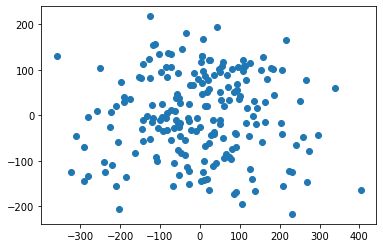

In [74]:
plt.scatter(pca[:,0], pca[:,1])

In [8]:
gmm = custom_gmm(data=pca, k=2,kmeans=False)
gmm.fit()
train_labels = gmm.get_labs()

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, shuffled_labels)

NameError: name 'train_labels' is not defined

In [12]:
def PCA_test():
    
    avg_accs = []
    
    for j in range(2,11):
        avg = np.zeros(50)
        pca = PCA(n_components=j).fit_transform(shuffled_data)
        
        for i in range(50):
            gmm = custom_gmm(data=pca, k=2,kmeans=False)
            gmm.fit()
            train_labels = gmm.get_labs()
    
            from sklearn.metrics import accuracy_score
            accuracy_score(train_labels, shuffled_labels)
    
            score1 = accuracy_score(train_labels, shuffled_labels)
            score2 = accuracy_score(train_labels, np.bitwise_not(shuffled_labels.astype(bool)))

            if score1 > score2:
                avg[i] = score1
            else:
                avg[i] = score2
                
        avg_accs.append(np.mean(avg))
        
    return avg_accs
        
    

In [7]:
avg_accs_PCA = PCA_test()

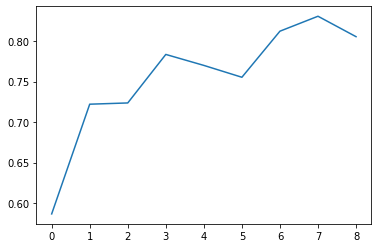

In [13]:
plt.plot(avg_accs_PCA)
plt.show()

In [ ]:
avg_accs = [0.586096866096866,
 0.7242165242165243,
 0.7171509971509973,
 0.7835327635327637,
 0.7765242165242163,
 0.7524216524216523,
 0.8165242165242168,
 0.8386894586894588,
 0.7904273504273505]



In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(gmm_train)
accuracy_score(kmeans.labels_, train_labels)

0.4188034188034188

In [14]:
def KM_test():
    avg_accs = []
    
    for j in range(2,11):
        
        avg = np.zeros(50)
        pca = PCA(n_components=j).fit_transform(shuffled_data)
        
        for i in range(50):
            kmeans = KMeans(n_clusters=2).fit(pca)
            train_labels = kmeans.labels_
    
            score1 = accuracy_score(train_labels, shuffled_labels)
            score2 = accuracy_score(train_labels, np.bitwise_not(shuffled_labels.astype(bool)))

            if score1 > score2:
                avg[i] = score1
            else:
                avg[i] = score2
        
        avg_accs.append(np.mean(avg))
            
    return avg_accs

In [15]:
avg_accs_KM = KM_test()

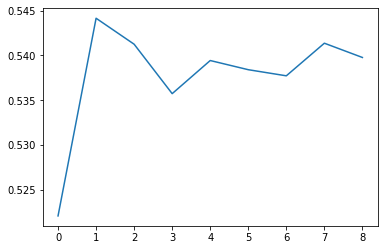

In [16]:
plt.plot(avg_accs_KM)
plt.show()

In [21]:
def Spectral_test():
    
    from sklearn.cluster import SpectralClustering
    avg_accs = []
    
    for j in range(2,11):
        
        avg = np.zeros(50)
        pca = PCA(n_components=j).fit_transform(shuffled_data)

        for i in range(50):
            spec = SpectralClustering(n_clusters=2).fit(pca)
            train_labels = spec.labels_
    
            score1 = accuracy_score(train_labels, shuffled_labels)
            score2 = accuracy_score(train_labels, np.bitwise_not(shuffled_labels.astype(bool)))

            if score1 > score2:
                avg[i] = score1
            else:
                avg[i] = score2
        
        avg_accs.append(np.mean(avg))
            
    return avg_accs

In [22]:
avg_accs_spec = Spectral_test()

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multip

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/uti

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_p

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in a

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/uti

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/uti

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/a

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/a

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/uti

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value e

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/uti

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multiply
  distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:368: RuntimeWarning: overflow encountered in multip

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:369: RuntimeWarning: invalid value encountered in add
  distances += XX
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:477: RuntimeWarning: overflow encountered in square
  elkan_iter(
/cluster/home/abobro01/123_pro

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph i

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


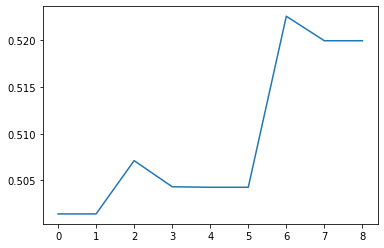

In [23]:
plt.plot(avg_accs_spec)
plt.show()

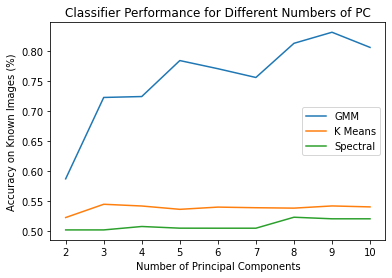

In [28]:
x = [2, 3, 4, 5, 6, 7, 8, 9, 10]
xi = list(range(len(x)))
plt.plot(avg_accs_PCA, label='GMM')
plt.plot(avg_accs_KM, label='K Means')
plt.plot(avg_accs_spec, label='Spectral')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy on Known Images (%)')
plt.title('Classifier Performance for Different Numbers of PC')
plt.xticks(xi, x)
plt.legend(loc='center right')
plt.savefig("classifier_performance")
plt.show()

In [77]:
pca = PCA(n_components=9).fit_transform(shuffled_data)
tsne = TSNE().fit(pca)

/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/cluster/home/abobro01/123_project_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


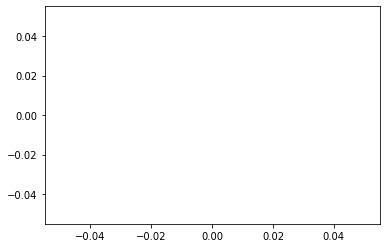

In [89]:
legend_alias = [plt.scatter([], [], marker='o', label='Pneumonia', edgecolors = 'gold', c='gold'),
                plt.scatter([], [], marker='o', label='Normal', edgecolors = 'indigo', c='indigo')]

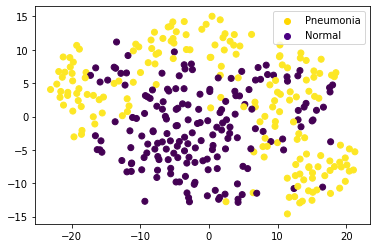

In [90]:
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=shuffled_labels)
plt.legend(handles=legend_alias)
plt.savefig("9-PCA to t-SNE actual labels")

In [7]:
gmm = custom_gmm(data=pca, k=2, kmeans=False, cov_init=10000)
gmm.fit()
vis_train_labels = gmm.get_labs()

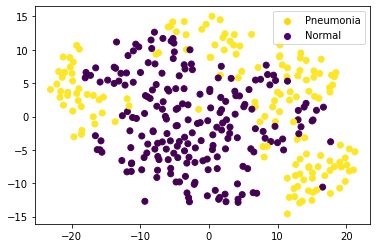

In [91]:
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=vis_train_labels)
plt.legend(handles=legend_alias)
plt.savefig("9-PCA to t-SNE classifier labels")

In [13]:
from sklearn.metrics import classification_report
print(classification_report(shuffled_labels, np.bitwise_not(vis_train_labels.astype(bool)), target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       176
           1       0.93      0.79      0.86       175

    accuracy                           0.87       351
   macro avg       0.87      0.87      0.87       351
weighted avg       0.87      0.87      0.87       351



In [82]:
shuffled_labels[0]

1.0

In [83]:
tsne.embedding_[0]

array([20.442966, -8.182978], dtype=float32)